# Analyzing COVID-19 Search Trends and Hospitalization

Group 39 : Yuqi Liu, Anthony Ma, Chenxuan Zhou


## Task 1: Acquire, preprocess, and analyze the data

In [1]:
ds1 = '2020_US_weekly_symptoms_dataset.csv'
ds2 = 'aggregated_cc_by.csv'
ds3 = '2020_US_Region_Mobility_Report.csv '

### Clean Dataset 1

In [2]:
import pandas as pd
import numpy as np

In [3]:
df1 = pd.read_csv(ds1)
# remove empty columns
df1 = df1.dropna(how='all', axis=1)
# region_name
df1 = df1.rename(columns={'sub_region_1': 'region_name'})
# convert string date to datetime
df1['date'] = df1['date'].astype('datetime64[ns]')
# Drop other codes and names
df1 = df1[[col for col in df1 if (col.startswith('symptom:') or col in ['date','region_name'])]]
# Drop empty columns
df1 = df1.dropna(axis=1,how='all')

# rename "symptom:aSymptom" to "aSymptom"
df1.columns = df1.columns.str.lstrip('symptom:')

# df1.to_csv('df1.csv', index=False)
df1

,region_name,date,Adrenal crisis,Ageusia,Allergic conjunctivitis,Amblyopia,Amenorrhea,Angular cheilitis,Anosmia,Aphonia,...,Tenderness,Thyroid nodule,Trichoptilosis,Upper respiratory tract infection,Urethritis,Urinary urgency,Vasculitis,Ventricular fibrillation,Viral pneumonia,Yawn
0,Alaska,2020-01-06,12.69,NaN,NaN,NaN,12.29,NaN,NaN,NaN,...,14.28,15.86,11.90,18.84,13.88,NaN,14.08,9.91,NaN,14.28
1,Alaska,2020-01-13,9.56,NaN,NaN,NaN,12.62,NaN,NaN,NaN,...,13.39,12.24,7.84,16.83,13.01,7.65,15.30,8.41,NaN,16.26
2,Alaska,2020-01-20,NaN,NaN,NaN,NaN,14.17,NaN,7.36,NaN,...,12.88,17.66,15.27,18.40,12.14,7.54,10.30,16.19,NaN,17.48
3,Alaska,2020-01-27,15.31,7.47,NaN,NaN,15.67,7.47,NaN,7.65,...,13.30,12.76,9.84,20.41,17.49,NaN,11.30,NaN,NaN,10.93
4,Alaska,2020-02-03,8.81,NaN,NaN,NaN,13.87,8.06,NaN,12.56,...,11.81,16.68,10.68,20.62,16.87,NaN,14.24,10.68,10.5,18.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,Wyoming,2020-08-24,4.42,3.31,3.42,5.19,3.42,NaN,2.65,NaN,...,3.98,3.87,2.26,3.98,4.09,NaN,3.64,2.48,NaN,3.87
604,Wyoming,2020-08-31,5.03,2.79,NaN,5.75,4.19,NaN,NaN,NaN,...,3.07,3.07,2.57,2.68,NaN,NaN,5.08,NaN,NaN,3.63
605,Wyoming,2020-09-07,3.36,3.25,2.20,3.63,NaN,2.25,2.70,NaN,...,4.29,2.81,NaN,3.19,3.19,NaN,4.51,NaN,NaN,4.02
606,Wyoming,2020-09-14,4.15,4.97,NaN,5.14,5.79,NaN,4.59,NaN,...,3.93,5.63,3.06,4.59,3.22,2.68,3.88,NaN,NaN,4.37


### Clean Dataset 2

In [4]:
df2 = pd.read_csv(ds2)

# select US regions
df2 = df2[df2['open_covid_region_code'].str.contains('US-')]
# reset index
df2.reset_index(drop=True, inplace=True)
# convert to weekly
df2['date'] = df2['date'].astype('datetime64[ns]')
df2 = df2.groupby("region_name").resample('W-Mon', label='right', closed = 'right', on='date').sum().reset_index()
# select columns
df2 = df2[['region_name', 'date', 'hospitalized_new']]


# df2.to_csv('df2.csv', index=False)
df2

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,region_name,date,hospitalized_new
0,Alabama,2020-03-09,0.0
1,Alabama,2020-03-16,0.0
2,Alabama,2020-03-23,0.0
3,Alabama,2020-03-30,0.0
4,Alabama,2020-04-06,240.0
...,...,...,...
1745,Wyoming,2020-09-07,4.0
1746,Wyoming,2020-09-14,11.0
1747,Wyoming,2020-09-21,17.0
1748,Wyoming,2020-09-28,17.0


### Merge datasets

In [5]:
merge_by = ['date','region_name']
df = pd.merge(df2, df1, on=merge_by)

#### Empty values

In [6]:
# drop cols with more than 25% non NaN values
# df = df.dropna(axis = 1, how='all')
df = df.dropna(thresh=0.25*df.shape[0], axis=1)

# drop rows with more than 50% non NaN values
df = df.dropna(thresh=0.25*df.shape[1], axis=0)

# fill the NaN with 0
df = df.fillna(0).reset_index(drop=True)
null_count = df.isnull().sum(axis=0).to_frame()

#### Demeaning

In [7]:
class DemeanWrapper:
    def __call__(self, df):
        transformed = df.iloc[:, 2:].copy()
        mean = transformed.mean()
        transformed = (transformed - mean) / mean
        return pd.DataFrame(transformed, columns=df.columns[2:], index=df.index)
    
df_rescaled = df.copy()
df_rescaled = (
    df_rescaled.groupby("region_name")
    .apply(DemeanWrapper())
)
df_rescaled.insert(loc=0, column='date', value=df['date'].values.ravel())
df_rescaled.insert(loc=0, column='region_name', value=df['region_name'].values.ravel())
df_rescaled['hospitalized_new'] = df['hospitalized_new']

# remove any row with inf.
df_rescaled = df_rescaled.replace([np.inf, -np.inf], np.nan).fillna(0)

df = df_rescaled


# df.to_csv('df.csv', index=False)
df

,region_name,date,hospitalized_new,Adrenal crisis,Ageusia,Allergic conjunctivitis,Amenorrhea,Angular cheilitis,Anosmia,Aphonia,...,Stridor,Subdural hematoma,Tachypnea,Tenderness,Thyroid nodule,Trichoptilosis,Urethritis,Urinary urgency,Ventricular fibrillation,Viral pneumonia
0,Alaska,2020-03-09,0.0,0.053136,-1.000000,1.320560,0.296390,-1.000000,-0.319199,5.113806,...,1.807165,1.557323,0.303076,0.165251,-0.093010,0.309871,-0.110451,-1.000000,-1.000000,5.147661
1,Alaska,2020-03-16,0.0,0.161431,-1.000000,0.277207,-1.000000,-1.000000,0.501229,5.144723,...,1.600194,-0.056150,0.149405,0.008805,0.182924,-0.152381,0.039395,-1.000000,-1.000000,7.133828
2,Alaska,2020-03-23,0.0,0.107780,2.061481,-1.000000,-0.034043,-1.000000,3.349615,-1.000000,...,1.180225,0.059705,0.484232,-0.064023,-0.377108,-0.216140,-0.237777,-1.000000,0.127831,3.497413
3,Alaska,2020-03-30,7.0,-0.109802,0.655454,0.421118,-0.135402,-1.000000,0.834407,-1.000000,...,1.513789,-0.259163,0.616664,-0.105382,-0.234243,0.386757,-0.150294,1.657304,0.139045,1.876518
4,Alaska,2020-04-06,16.0,0.001473,0.357989,-1.000000,0.094684,1.591318,-0.348087,-1.000000,...,-1.000000,-0.096540,0.205626,-0.171018,-0.294654,0.296744,-0.126908,-1.000000,-1.000000,1.958052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Wyoming,2020-08-24,16.0,0.248223,0.571803,1.638468,0.160136,-1.000000,-0.242185,-1.000000,...,-1.000000,-0.188449,-1.000000,0.159650,0.051828,-0.222262,0.344937,-1.000000,1.063702,-1.000000
258,Wyoming,2020-08-31,4.0,0.420489,0.324873,-1.000000,0.421336,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.179815,0.227561,-0.105496,-0.165604,-0.115581,-1.000000,-1.000000,-1.000000,-1.000000
259,Wyoming,2020-09-07,4.0,-0.051125,0.543311,0.697260,-1.000000,4.605670,-0.227887,-1.000000,...,1.746086,0.505111,1.858335,0.249975,-0.236270,-1.000000,0.048985,-1.000000,-1.000000,-1.000000
260,Wyoming,2020-09-14,11.0,0.171974,1.360079,-1.000000,0.964089,-1.000000,0.312592,-1.000000,...,1.845743,-0.073335,-1.000000,0.145082,0.530178,0.053044,0.058850,2.843719,-1.000000,-1.000000


#### Symptom selction

1. No feature selection

In [8]:
# do nothing

2. modification 1: use only the selected features (Viral pneumonia, Laryngitis, Anosmia, Aphonia)  
(DO NOT run visualizaiton and PCA models)

In [9]:
'''
symp_l = ["Viral pneumonia", "Upper respiratory tract infection", "Laryngitis","Anosmia", "Aphonia", "region_name",
         "date","hospitalized_new" ]

df = df[df.columns & symp_l]
df
'''

'\nsymp_l = ["Viral pneumonia", "Upper respiratory tract infection", "Laryngitis","Anosmia", "Aphonia", "region_name",\n         "date","hospitalized_new" ]\n\ndf = df[df.columns & symp_l]\ndf\n'

3. modification 2: drop those selected features 

In [10]:
'''
del df["Viral pneumonia"]
del df["Anosmia"]
del df["Aphonia"]
del df["Laryngitis"]

df
'''

'\ndel df["Viral pneumonia"]\ndel df["Anosmia"]\ndel df["Aphonia"]\ndel df["Laryngitis"]\n\ndf\n'

## Task 2: Visualize and cluster the data

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
%matplotlib inline

### Visualization
Plot heatmap to visualize symptom search popularity

we group the dataset by time and take average of scores in all regions with weekly date being “row names”. Then applying heatmap to visualize, we find that there are several symptoms with high variability in popularity across time. This makes sense since we do have some features that only contains very little amount of data since they only show up in few regions, which will be discarded in our merging step in Task1. While taking average of this can help us at least keep in mind there are some features showing great variation while being discarded due to the insufficient time.

#### Visualization over symptoms

In [12]:
df_by_time = df1.groupby('date').mean().reset_index()
df_by_time.fillna(0,inplace=True)
df_by_time.shape # we have nearly 130 features

(38, 122)

Text(68.99999999999999, 0.5, 'Symptoms')

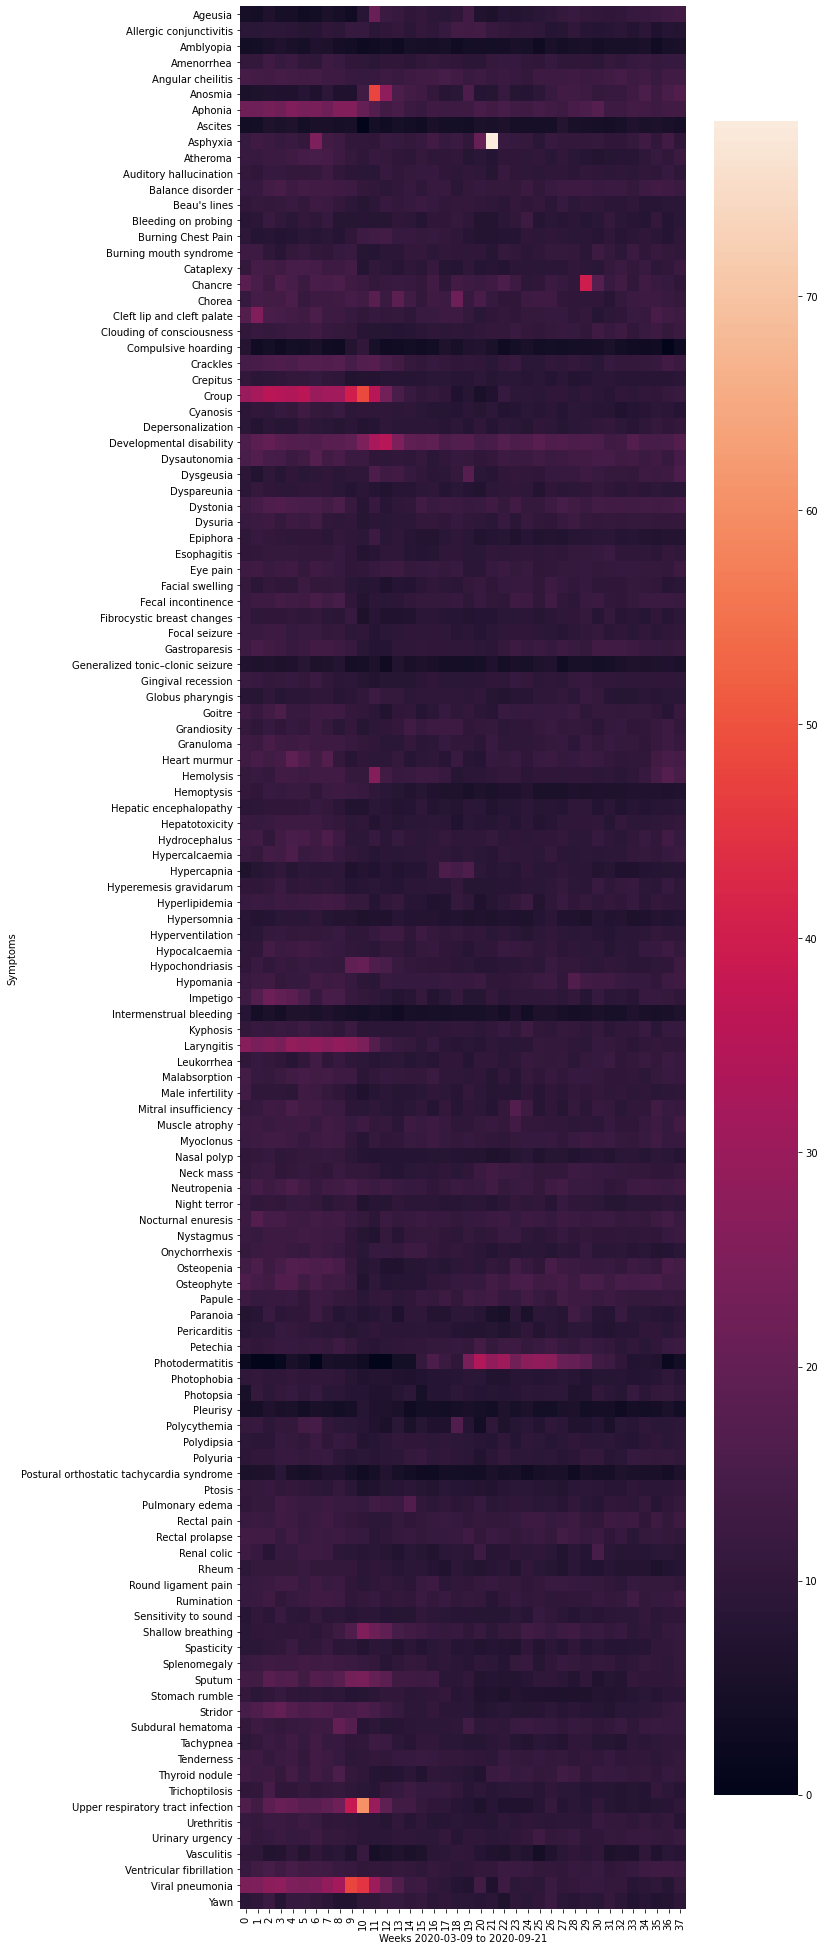

In [13]:
plt.figure(figsize = (10,35))

heat_map = sb.heatmap(df_by_time.iloc[:,2:].T)  # --> Croup, Developmental disability is the popular one

plt.xlabel("Weeks 2020-03-09 to 2020-09-21")
plt.ylabel('Symptoms') 

#plt.savefig('img/symptoms.png', bbox_inches = "tight")
plt.show(bbox_inches = "tight")

#### Visualization over Region

Heatmap of **viral pneumonia** search trend over regions over time.

[Text(41.99999999999999, 0.5, 'region name')]

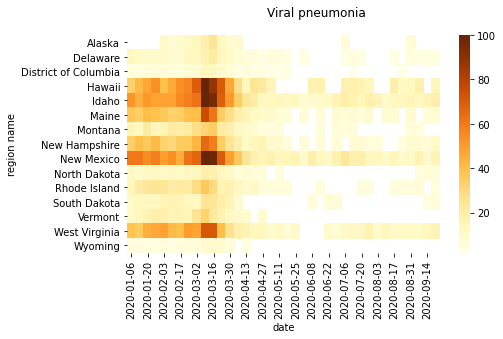

In [14]:
df_region = df1[['region_name', 'date', 'Viral pneumonia']].copy()
# show date in "%Y-%m-%d" format
df_region['date'] = df_region['date'].apply(lambda x : x.strftime("%Y-%m-%d"))

heatmap1_data = pd.pivot_table(df_region, values='Viral pneumonia', 
                               index=['region_name'], columns='date')
plt.figure(figsize=(7, 4))
plt.suptitle('Viral pneumonia')
ax = sb.heatmap(heatmap1_data, cmap="YlOrBr")
ax.set(ylabel='region name')

#plt.savefig('img/viral_pneumonia.png', bbox_inches = "tight")
plt.show()

Heatmap of **Laryngitis** search trend over regions over time.

[Text(41.99999999999999, 0.5, 'region name')]

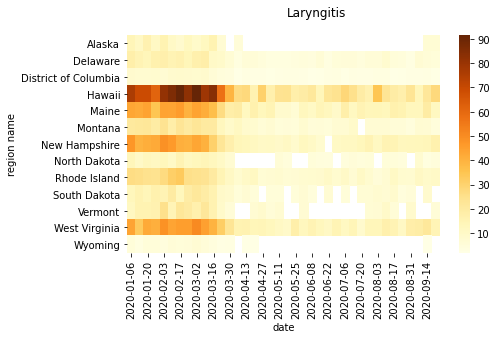

In [15]:
symptom = 'Laryngitis'

df_region = df1[['region_name', 'date', symptom]].copy()
# show date in "%Y-%m-%d" format
df_region['date'] = df_region['date'].apply(lambda x : x.strftime("%Y-%m-%d"))

heatmap1_data = pd.pivot_table(df_region, values=symptom, 
                               index=['region_name'], columns='date')
plt.figure(figsize=(7, 4))
plt.suptitle(symptom)
ax = sb.heatmap(heatmap1_data, cmap="YlOrBr")
ax.set(ylabel='region name')

#plt.savefig('img/laryngitis.png', bbox_inches = "tight")
plt.show()

Heatmap of **Anosmia** search trend over regions over time.

[Text(42.0, 0.5, 'region name')]

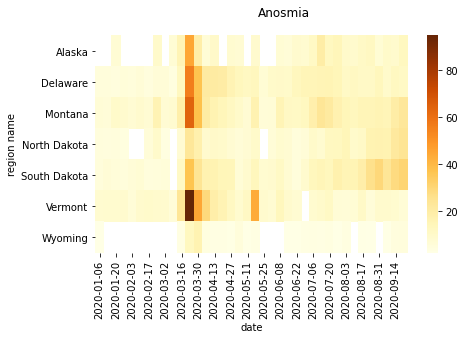

In [16]:
symptom = 'Anosmia'
df_region = df1[['region_name', 'date', symptom]].copy()
# show date in "%Y-%m-%d" format
df_region['date'] = df_region['date'].apply(lambda x : x.strftime("%Y-%m-%d"))

heatmap1_data = pd.pivot_table(df_region, values=symptom, 
                               index=['region_name'], columns='date')
plt.figure(figsize=(7, 4))
plt.suptitle(symptom)
ax = sb.heatmap(heatmap1_data, cmap="YlOrBr")
ax.set(ylabel='region name')

#plt.savefig('img/anosmia.png', bbox_inches = "tight")
plt.show()

Heatmap of **Aphonia** search trend over regions over time.

[Text(41.99999999999999, 0.5, 'region name')]

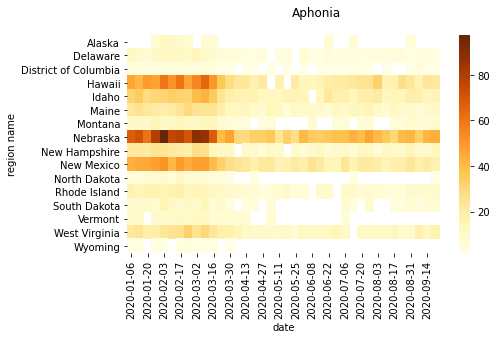

In [17]:
df_region = df1[['region_name', 'date', 'Aphonia']].copy()
# show date in "%Y-%m-%d" format
df_region['date'] = df_region['date'].apply(lambda x : x.strftime("%Y-%m-%d"))

heatmap1_data = pd.pivot_table(df_region, values='Aphonia', 
                               index=['region_name'], columns='date')
plt.figure(figsize=(7, 4))
plt.suptitle('Aphonia')
ax = sb.heatmap(heatmap1_data, cmap="YlOrBr")
ax.set(ylabel='region name')

#plt.savefig('img/aphonia.png', bbox_inches = "tight")
plt.show()

Heatmap of  **hospitalization_new** over regions over time.

[Text(41.99999999999999, 0.5, 'region name')]

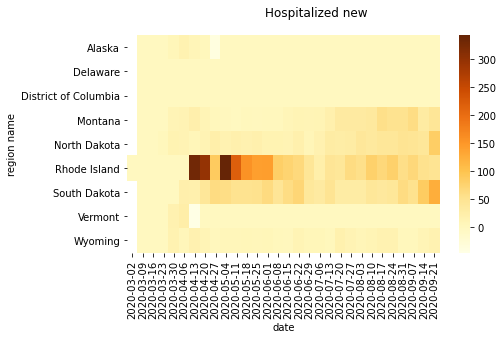

In [18]:
df2_region = df[['region_name', 'date', 'hospitalized_new']].copy()
# show date in "%Y-%m-%d" format
df2_region['date'] = df2_region['date'].apply(lambda x : x.strftime("%Y-%m-%d"))

heatmap1_data = pd.pivot_table(df2_region, values='hospitalized_new', 
                               index=['region_name'], columns='date')
plt.figure(figsize=(7, 4))
plt.suptitle('Hospitalized new')
ax = sb.heatmap(heatmap1_data, cmap="YlOrBr")
ax.set(ylabel='region name')

#plt.savefig('img/hospitalization_new.png', bbox_inches = "tight")
plt.show()

### PCA

original shape:  (262, 92)
transformed shape: (262, 2)


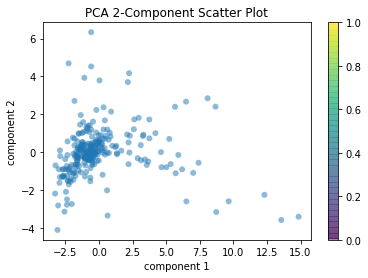

In [19]:
#Standardize it by subtracting the mean of each symptom
#df_rescaled_by_means
X = df.iloc[:, 3:].apply(lambda col: col - col.mean() ,axis = 0)
'''standardize by subtract means?'''

pca = PCA(n_components=2)

search_trend_pca = pca.fit_transform(X)
print("original shape: ", X.shape)
print("transformed shape:", search_trend_pca.shape)

# plot the first two principal components of each point
plt.scatter(search_trend_pca[:, 0], search_trend_pca[:, 1], edgecolor='none', alpha=0.5)
plt.title('PCA 2-Component Scatter Plot')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

#plt.savefig('img/pca_2_component.png', bbox_inches = "tight")
plt.show()

Visualize the cumulative explained variance to see how many features are enough to cover a majority of information

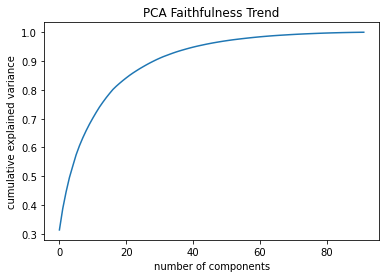

In [20]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_)) # --> choose 5 maybe
plt.title('PCA Faithfulness Trend')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

#plt.savefig('img/pca_faithfulness.png', bbox_inches = "tight")
plt.show()

### Kmeans

In [21]:
from sklearn.cluster import KMeans

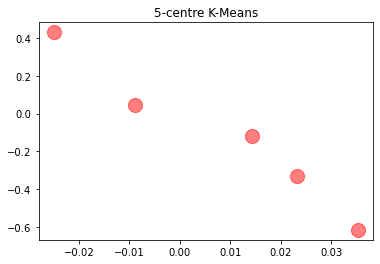

In [22]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_

plt.title('5-centre K-Means')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha= 0.5);

#plt.savefig('img/k_means.png', bbox_inches = "tight")
plt.show()

Compare with the data after PCA

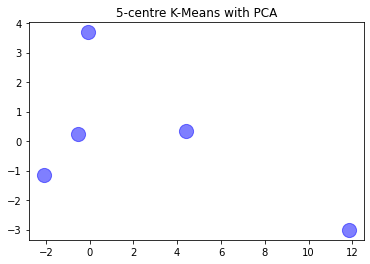

In [23]:
X_pca = search_trend_pca

kmeans_pca = KMeans(n_clusters=5)
kmeans_pca.fit(X_pca)
y_kmeans_pca = kmeans_pca.predict(X_pca)
centers_PCA = kmeans_pca.cluster_centers_

plt.title('5-centre K-Means with PCA')
p2 = plt.scatter(centers_PCA[:, 0], centers_PCA[:, 1], c='blue', s=200, alpha= 0.5);

#plt.savefig('img/k_means_pca.png', bbox_inches = "tight")
plt.show()

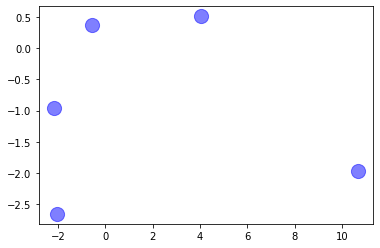

In [24]:
# this time select 5 PCs to see K-means clustering performance
pca_2 = PCA(n_components=5)
search_trend_pca_2 = pca_2.fit_transform(X)

# Do kmeans
X_pca = search_trend_pca_2
kmeans_pca = KMeans(n_clusters=5)
kmeans_pca.fit(X_pca)
y_kmeans_pca = kmeans_pca.predict(X_pca)

centers_PCA = kmeans_pca.cluster_centers_
p2 = plt.scatter(centers_PCA[:, 0], centers_PCA[:, 1], c='blue', s=200, alpha= 0.5);


As we can see, the clusters in this plot above actually differs from the one with Kmeans applying on the whole dataset, with an obvious difference of cluster on the upper left corner, which may suggest an outlier of data (noise). By PCA with 7 PCs, we may have a better performance on the following supervised learning tasks.

## Task 3: Supervised Learning

In [25]:
from collections import defaultdict
model_performances = defaultdict(int)

### Split by region
5-fold cross validation split by region.

In [26]:
# obtain input and target
input = df.copy()
del input['hospitalized_new']
target = df.loc[:, ['hospitalized_new']].copy()

# Get X_train and y_train
input_region = input.iloc[:, 2:].copy()
X_train=input_region.values
y_train=target.values.ravel()

# Get cross-validation group indices
states = list(set(input['region_name']))
level = len(states)/5
groups_region = input['region_name'].apply(lambda x : int(states.index(x)/level) if int(states.index(x)/level) < 4 else 4)
groups_region = groups_region.values

#### region KNN

Text(0, 0.5, '5-fold cross-validation loss')

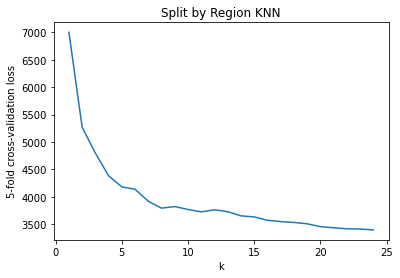

In [27]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)

k_range = range(1, 25) # n_neighbors
k_scores = []

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    loss = abs(cross_val_score(knn, X_train, y_train, cv=gkf.split(X_train, y_train, groups_region), scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())

plt.plot(k_range, k_scores)
plt.title('Split by Region KNN')
plt.xlabel('k')
plt.ylabel('5-fold cross-validation loss')

#plt.savefig('img/region_knn.png')
plt.show()

In [28]:
# chosen model
k = 15
print("n_neighbors : {}\nunscaled cross validation loss: {}".format(k,k_scores[k-1]))
model_performances['region KNN'] = k_scores[k-1]

n_neighbors : 15
unscaled cross validation loss: 3632.201743749594


#### region Decision Tree

Text(0, 0.5, '5-fold cross-validation loss')

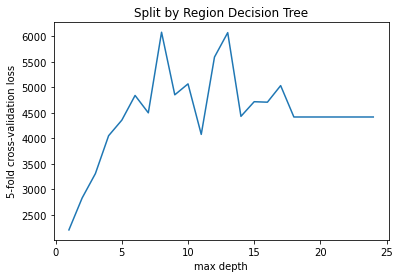

In [29]:
from sklearn.tree import DecisionTreeRegressor
d_range = range(1, 25) # max_depth
d_scores = []
for d in d_range :
    dt = DecisionTreeRegressor(max_depth=d, random_state=3)
    loss = abs(cross_val_score(dt, X_train, y_train, cv=gkf.split(X_train, y_train, groups_region), scoring='neg_mean_squared_error'))
    d_scores.append(loss.mean())

plt.plot(d_range, d_scores)
plt.title('Split by Region Decision Tree')
plt.xlabel('max depth')
plt.ylabel('5-fold cross-validation loss')

#plt.savefig('img/region_dt.png')

In [30]:
# chosen model
d = 1
print("max_depth : {}\nunscaled cross validation loss: {}".format(d,d_scores[d-1]))
model_performances['region decision tree'] = d_scores[d-1]

max_depth : 1
unscaled cross validation loss: 2202.9294966254256


### Split by time
Keep data for the last couple of timepoints (after `2020-08-10`) from
all regions in the validation set ; train on the rest of the data

In [31]:
times = df.copy()
times = times.drop("region_name", axis=1)
times = times.sort_values('date').reset_index(drop=True)

# Get X and y

input_times = times.copy()
del input_times['date']
del input_times['hospitalized_new']

times_target = times.loc[:, ['hospitalized_new']].copy()

# select last 20% dates for training
test_dates = sorted(list(set(times['date'])))
test_dates_ind = int(0.2 * len(test_dates))
test_dates = test_dates[-test_dates_ind:]
test_ind = times.loc[times['date'].isin(test_dates)].index[0]

test_data = input_times.iloc[test_ind:]
train_data = input_times.iloc[:test_ind]
test_target = times_target.iloc[test_ind:]
train_target = times_target.iloc[:test_ind]

# obtain np_arrays
X_train=train_data.values
y_train=train_target.values.ravel()

X_test=test_data.values
y_test=test_target.values.ravel()

#### time KNN

Text(0, 0.5, '20% validation loss')

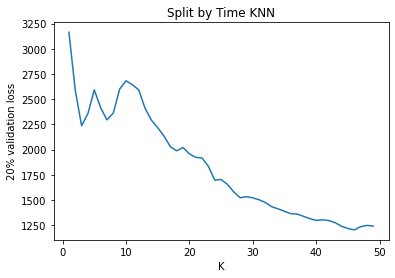

In [32]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold

k_range = range(1, 50)
k_scores = []

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    loss = np.mean((knn.predict(X_test) - y_test)**2)
    k_scores.append(loss.mean())

plt.plot(k_range, k_scores)
plt.title('Split by Time KNN')
plt.xlabel('K')
plt.ylabel('20% validation loss')

#plt.savefig('img/time_knn.png')

In [33]:
# chosen model
k = 46
print("n_neighbors : {}\nunscaled cross validation loss: {}".format(k,k_scores[k-1]))
model_performances['time KNN'] = k_scores[k-1]

n_neighbors : 46
unscaled cross validation loss: 1202.9403224112582


#### time Decision Tree

Text(0, 0.5, '20% validation loss')

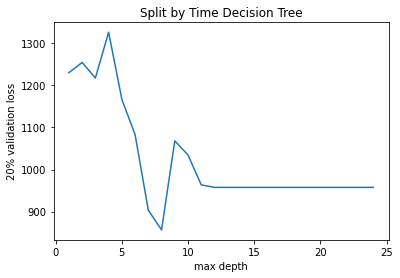

In [34]:
from sklearn.tree import DecisionTreeRegressor
d_range = range(1, 25) # max_depth
d_scores = []
for d in d_range :
    dt = DecisionTreeRegressor(max_depth=d, random_state=3)
    dt.fit(X_train, y_train)
    loss = np.mean((dt.predict(X_test) - y_test)**2)
    d_scores.append(loss.mean())

plt.plot(d_range, d_scores)
plt.title('Split by Time Decision Tree')
plt.xlabel('max depth')
plt.ylabel('20% validation loss')

#plt.savefig('img/time_dt.png')

In [35]:
# chosen model
d = 8
print("max_depth : {}\nunscaled cross validation loss: {}".format(d,d_scores[d-1]))
model_performances['time decision tree'] = d_scores[d-1]
# statistics.mean(d_scores)

max_depth : 8
unscaled cross validation loss: 856.6399856940749


### Extra : Learning using PCA data

In [36]:
# Get X and y for PCA
X = df.iloc[:, 3:].copy() # all symptoms
pca = PCA(n_components=5)
X = pca.fit_transform(X)
y = df['hospitalized_new'].values.ravel()

#### PCA with KNN

Text(0, 0.5, '5-fold cross-validation loss')

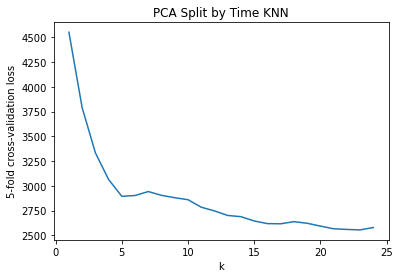

In [37]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False)

k_range = range(1, 25)
k_scores = []

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    # knn.fit(X_train, y_train)
    # loss = np.mean((knn.predict(X_test) - y_test)**2)
    loss = abs(cross_val_score(knn, X, y, cv=kf.split(X, y), scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())
    
plt.plot(k_range, k_scores)
plt.title('PCA Split by Time KNN')
plt.xlabel('k')
plt.ylabel('5-fold cross-validation loss')

#plt.savefig('img/pca_knn.png')

In [38]:
# chosen model
k = 23
print("n_neighbors : {}\nunscaled cross validation loss: {}".format(k,k_scores[k-1]))
model_performances['PCA by time KNN'] = k_scores[k-1]

n_neighbors : 23
unscaled cross validation loss: 2553.7100972341495


#### PCA with decision tree

Text(0, 0.5, '5-fold cross-validation loss')

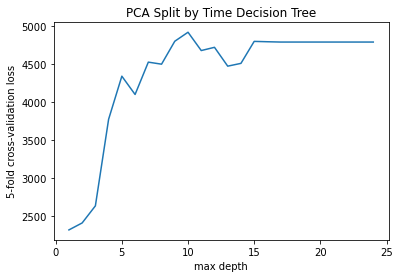

In [39]:
# Decision tree

from sklearn.tree import DecisionTreeRegressor
d_range = range(1, 25) # max_depth
d_scores = []
for d in d_range :
    dt = DecisionTreeRegressor(max_depth=d, random_state=1)
    # dt.fit(X_train, y_train)
    # loss = np.mean((dt.predict(X_test) - y_test)**2)
    loss = abs(cross_val_score(dt, X, y, cv=kf.split(X, y), scoring='neg_mean_squared_error'))
    d_scores.append(loss.mean())
plt.plot(d_range, d_scores)
plt.title('PCA Split by Time Decision Tree')
plt.xlabel('max depth')
plt.ylabel('5-fold cross-validation loss')

#plt.savefig('img/pca_dt.png')

In [40]:
# chosen model
d = 1
print("max_depth : {}\nunscaled cross validation loss: {}".format(d,d_scores[d-1]))
model_performances['PCA by time decision tree'] = d_scores[d-1]

max_depth : 1
unscaled cross validation loss: 2320.1228631438726


#### PCA with linear regression 

y is the hospitalization case number

In [41]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)

loss = abs(cross_val_score(lr, X, y, cv=kf.split(X, y), scoring='neg_mean_squared_error'))
loss = loss.mean()

print(loss)
model_performances['PCA by time linear regression'] = loss

2332.503779237798


### Extra : Mobility prediction KNN (baseline)

In [42]:
df3 = pd.read_csv(ds3)
df3 = df3[df3['iso_3166_2_code'].notna()].reset_index()
df3 = df3.drop(['index', 'country_region_code', 'country_region', 'sub_region_2', 'metro_area','iso_3166_2_code','census_fips_code'],axis=1)

In [43]:
# convert from daily to weekly
df3['date'] = df3['date'].astype('datetime64[ns]')
df3.groupby("sub_region_1").resample('W-Sat', label='right', closed = 'right', on='date').sum().reset_index()

# merge with hospitalization
merge_by = ['date','region_name']
df2['date'] = df2['date'].astype('datetime64[ns]')
df3 = df3.rename(columns={'sub_region_1': 'region_name'})
df3 = pd.merge(df2, df3, on=merge_by)
df3 = df3.fillna(0)

# keep datapoints that align with dataset1
df_region_time = df[["region_name", "date"]]
df3 = pd.merge(df_region_time, df3, on=merge_by)

# separate input and target sets
input_times = df3.copy()
times_target = input_times['hospitalized_new']
del input_times['date']
del input_times['hospitalized_new']
del input_times['region_name']

# X and y
X = input_times.values
y = times_target.values.ravel()

Text(0, 0.5, '5-fold cross-validation loss')

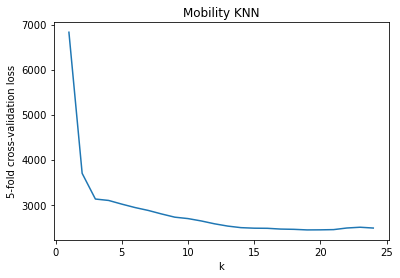

In [44]:
k_range = range(1, 25) # n_neighbors
k_scores = []

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    loss = abs(cross_val_score(knn, X, y, cv=kf.split(X, y), scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())

import matplotlib.pyplot as plt 
plt.plot(k_range, k_scores)
plt.title('Mobility KNN')
plt.xlabel('k')
plt.ylabel('5-fold cross-validation loss')

#plt.savefig('img/mobiliy_knn.png')

In [45]:
# chosen model
k = 15
print("n_neighbors : {}\nunscaled cross validation loss: {}".format(k,k_scores[k-1]))
model_performances['mobility KNN'] = k_scores[k-1]
#statistics.mean(k_scores)

n_neighbors : 15
unscaled cross validation loss: 2478.208415416868


## Model Comparison

<BarContainer object of 8 artists>

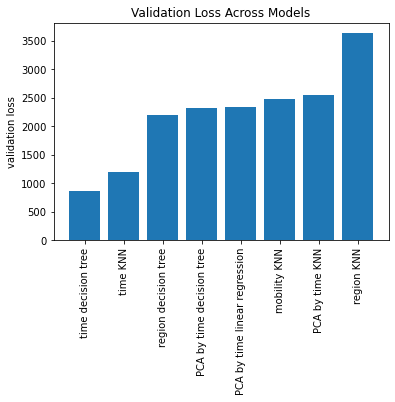

In [46]:
import matplotlib.pyplot as plt
model_performances = {k: v for k, v in sorted(model_performances.items(), key=lambda item: item[1])}
plt.title('Validation Loss Across Models')
plt.xticks(rotation='vertical')
plt.ylabel('validation loss')
plt.bar(list(model_performances.keys()), model_performances.values())

#plt.savefig('img/model_comparison.png', bbox_inches = "tight")